# An example of using Open Humans notebooks for activity data analysis

## Getting started

In this notebook we want to compare our personal `fitbit` and `Apple HealthKit` data. If you want to run this notebook on your personal data in the [*Open Humans Notebooks*](https://notebooks.openhumans.org) you need to have both [*Fitbit*](https://www.openhumans.org/activity/fitbit) as well as the [*HealthKit Integration*](https://www.openhumans.org/activity/open-humans-healthkit-integration/) data in your Open Humans account.

#### Initialize packages
We'll need some Python packages to get our personal data out of Open Humans and to play around with it.

In [1]:
%matplotlib inline

import os, requests, json
import datetime
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Let's now start by getting a list of all the data we have on Open Humans. To do this we need our `access_token`. Using the `os` library we can access it from the environment variables which are set in our notebooks using `os.environ.get('OH_ACCESS_TOKEN')`

In [2]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)

We now have a `json` object that contains all the details about our user account. We can look at it:

In [3]:
#user #commented out to not leak all download links ;)
#os.environ.get("OH_ACCESS_TOKEN")
print("not for the published notebook ;-)")

not for the published notebook ;-)


Amongst the keys we see that `user["data"]` gives us a list with all data files. Iterating over it gives us the following:

In [4]:
for i,f in enumerate(user['data']):
    print("{}\t{}".format(i,f['basename']))

0	1.json
1	healthkit-export_2015-11-01_2015-11-30_1511288864.58225.json
2	healthkit-export_2015-12-01_2015-12-31_1511288864.58225.json
3	healthkit-export_2015-12-31_2016-01-31_1511297617.26078.json
4	healthkit-export_2016-02-01_2016-02-29_1511297617.26078.json
5	healthkit-export_2016-03-01_2016-03-31_1511297617.26078.json
6	healthkit-export_2016-04-01_2016-04-30_1511297617.26078.json
7	healthkit-export_2016-05-01_2016-05-31_1511297617.26078.json
8	healthkit-export_2016-06-01_2016-06-30_1511297617.26078.json
9	healthkit-export_2016-07-01_2016-07-31_1511297617.26078.json
10	healthkit-export_2016-08-01_2016-08-31_1511297617.26078.json
11	healthkit-export_2016-09-01_2016-09-30_1511297617.26078.json
12	healthkit-export_2016-10-01_2016-10-31_1511297617.26078.json
13	healthkit-export_2016-11-01_2016-11-30_1511297617.26078.json
14	healthkit-export_2016-12-01_2016-12-31_1511297617.26078.json
15	healthkit-export_2017-01-01_2017-01-31_1511297617.26078.json
16	healthkit-export_2017-02-01_2017-02-2

Let's iterate again and grab ouy fitbit data 

## Getting Fitbit data

In [5]:
for f in user['data']:
    if f['source'] == "fitbit":
        fitbit_download_url = f['download_url']
        break
if not fitbit_download_url: 
    print("NO FITBIT DATA FOUND!")

To download the data we can use `requests` and subsequently convert the downloaded content into a `JSON` object

In [6]:
fitbit_temp = requests.get(fitbit_download_url).content
fitbit = json.loads(fitbit_temp)
fitbit.keys()

dict_keys(['sleep-start-time', 'awake-minutes', 'tracker-minutes-very-active', 'profile', 'minutes-to-sleep', 'tracker-floors', 'sleep-minutes', 'sleep-awakenings', 'tracker-minutes-lightly-active', 'tracker-calories', 'activities-overview', 'weight-log', 'time-in-bed', 'tracker-distance', 'sleep-minutes-after-wakeup', 'tracker-minutes-fairly-active', 'tracker-elevation', 'weight', 'heart', 'tracker-steps', 'sleep-efficiency', 'tracker-minutes-sedentary', 'tracker-activity-calories'])

The keys give us an idea what data is in our fitbit store. Let's have a quick look at the step counts. To do this we convert our JSON file into a `pandas` dataframe which can then be used for plotting.

## Visualizing Fitbit steps

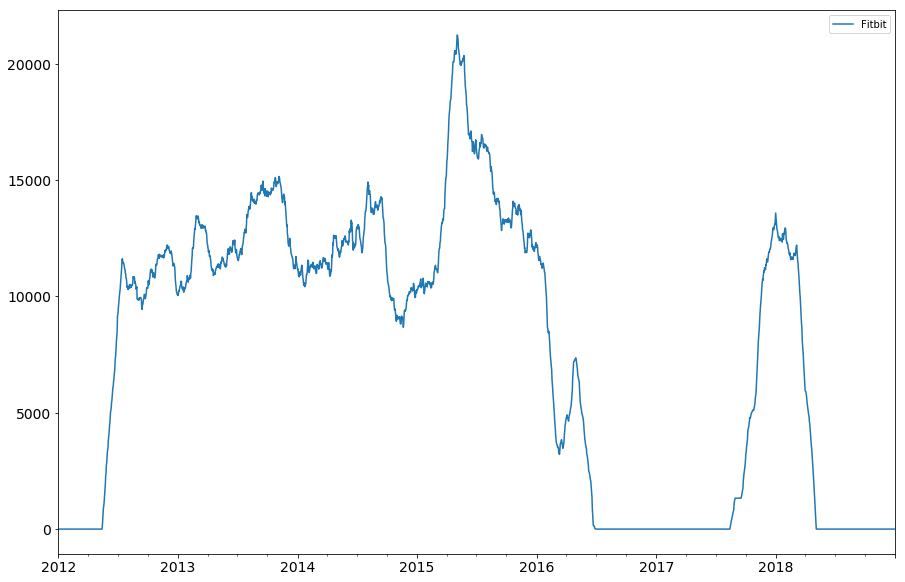

In [7]:
dates = []
steps = []
for year in fitbit['tracker-steps']:
    for entry in fitbit['tracker-steps'][year]['activities-tracker-steps']:
        dates.append(datetime.datetime.strptime(entry['dateTime'], '%Y-%m-%d'))
        steps.append(int(entry['value']))
fitbit_df = pd.DataFrame(data = {'date': dates, 
                          'steps': steps})
fitbit_df.sort_values(by=['date'],inplace=True)
fitbit_df.index = fitbit_df["date"]

fitbit_df = fitbit_df.groupby(fitbit_df.index.date).sum()
fitbit_df.index = pd.to_datetime(fitbit_df.index)
fitbit_dfr = fitbit_df.rolling('60d').mean()
fitbit_pt = fitbit_dfr.plot(y=['steps'],figsize=(15,10),fontsize=14)
fitbit_pt.legend(["Fitbit"])

## Let's get our HealthKit data

In a first step let's get all healthkit file URLs. As the *HealthKit importer* uploads a number of JSON files we want to save all of them as a list:

In [8]:
healthkit_urls = []
for f in user['data']:
    if f['source'] == "direct-sharing-14":
        healthkit_urls.append(f['download_url'])

Now let's quickly grab all the steps collected and sum them up for a single day. For this we make a `for` loop over all the download URLs, download the content with `requests` and then import the content with `json.loads()`. Ultimately we save all daily steps in a dictionary called `healthkit_steps`

In [9]:
from collections import defaultdict
healthkit_steps = defaultdict(int)
for url in healthkit_urls:
    healthkit_content = requests.get(url).content
    try:
        healthkit_json = json.loads(healthkit_content)
        for entry in healthkit_json['HKQuantityTypeIdentifierStepCount']:
            date = entry['sdate'][:10]
            steps = entry['value']
            healthkit_steps[date] += steps
    except json.JSONDecodeError: 
        next

Now we can convert this dictionary into a nicely formatted `pandas.dataframe`. First we iterate over the `date` and `steps` in our dictionary and convert them into two lists. From there we can create the `pd.DateFrame`. After doing this we can start plotting our steps as measured by `HealthKit`

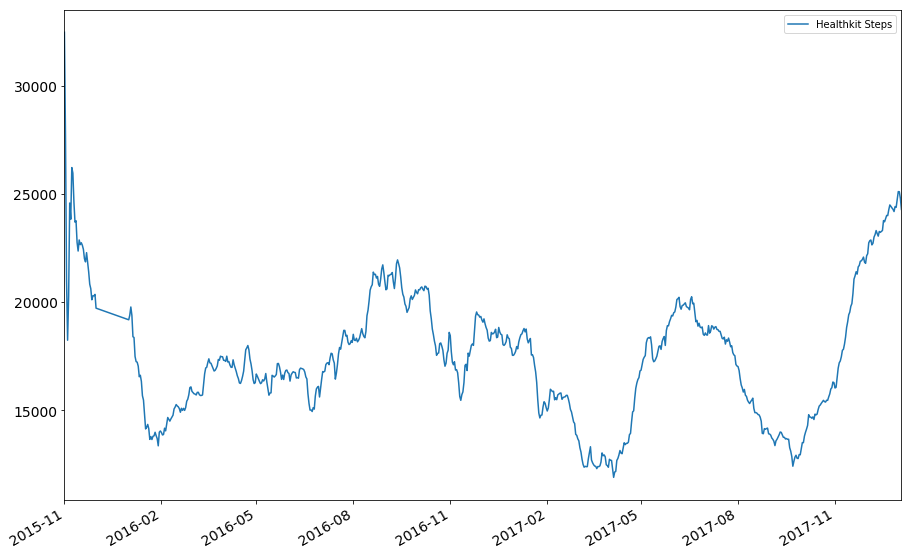

In [10]:
healthkit_dates = []
healthkit_data = []
for date,steps in healthkit_steps.items():
    healthkit_dates.append(datetime.datetime.strptime(date, '%Y-%m-%d'))
    healthkit_data.append(steps)
    
hk_df = pd.DataFrame(data = {'date': healthkit_dates, 
                          'hk_steps': healthkit_data})
hk_df.sort_values(by=['date'],inplace=True)
hk_df.index = hk_df["date"]

hk_df = hk_df.groupby(hk_df.index.date).sum()
hk_df.index = pd.to_datetime(hk_df.index)
hk_dfr = hk_df.rolling('60d').mean()
hk_pt = hk_dfr.plot(y=['hk_steps'],figsize=(15,10),fontsize=14)
hk_pt.legend(["Healthkit Steps"])

## Comparing HealthKit & Fitbit data
In the next step we merge the two data sources, from `fitbit_df` and `hk_df` into a single dataframe using the dates as the keys. To remove some of the noise we also remove all the `fitbit_df` step entries that are `0`, as most of these represent days in which the tracker wasn't worn and not actually not moving at all. Afterwards we can plot our merged data to see how they compare to each other.

In [11]:
df_merged = pd.merge(fitbit_df.reset_index(),hk_df.reset_index(),on="index", how='outer')

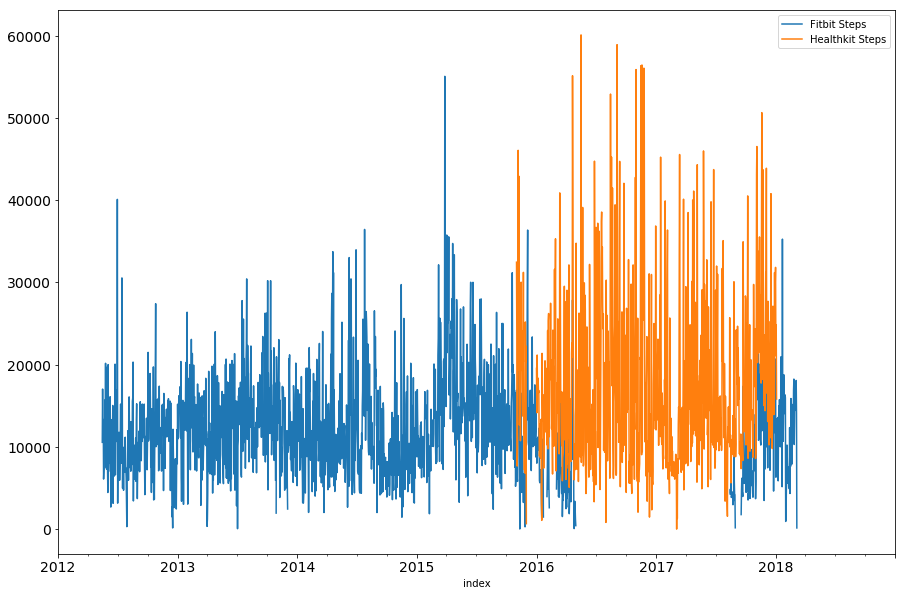

In [12]:
df_merged.index = df_merged["index"]
df_merged = df_merged.replace(0, np.nan)
hk_pt = df_merged.plot(y=['steps','hk_steps'],figsize=(15,10),fontsize=14)
hk_pt.legend(["Fitbit Steps","Healthkit Steps"])

This looks weird. For the overlaps at the end of 2015 and starting of end of 2710 we see that `HealthKit` data seems to yield much higher values than the `Fitbit` data. But does this represent a consistent signal? Let's switch to a scatterplot. With the small function `add_identity` we can also plot a diagonal that represents the case where `fitbit == healthkit`. 

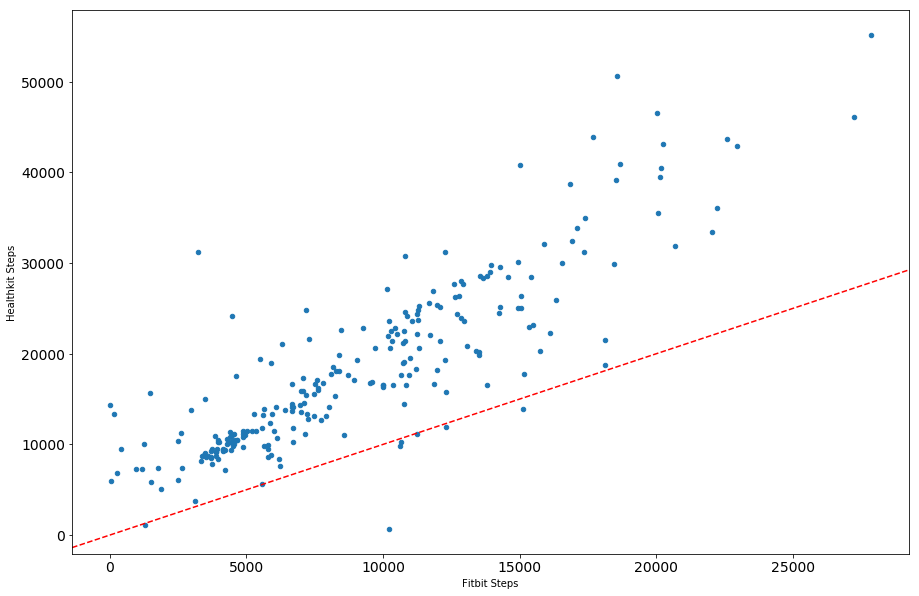

In [13]:
import numpy as np

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


scatter_pt = df_merged.plot.scatter("steps", "hk_steps",figsize=(15,10),fontsize=14)
scatter_pt.set_xlabel("Fitbit Steps")
scatter_pt.set_ylabel("Healthkit Steps")
add_identity(scatter_pt, color='r', ls='--')

And sure enough, we do find a systematic error. `Healthkit` almost consistently reports `~2x` as many steps as `Fitbit` does. So it looks like you should always trust `HealthKit` if you easily want to make your 10,000 steps!

### But what's really going on here?! 

I think the error has a rather simple reason: In my personal case `HealthKit` is tracking steps using two different methods: 

1. My `iPhone` and its internal accelerometer/gyroscope are feeding data into HealthKit when I'm carrying it around and they detect movement
2. I'm also wearing an `Apple Watch`, which in just the same way records steps over the day (along with heart rate measurements etc.). And the data collected by the Watch end up in HealthKit too. 

Which yields us roughly 2x as many recorded steps as compared to `Fitbit`, which only stores the steps recorded by its own hardware tracker. 

On their end Apple cleverly manage this double recording of data: In cases where two data sources record steps at roughly the same time it will give the data recorded by the `Apple Watch` the lead and ignore the data recorded by the phone. Our complete export of the data done by the [`Open Humans HealthKit integration`](https://www.openhumans.org/activity/open-humans-healthkit-integration/) on the other hand does not differentiate between the two data sources and instead grabs all the step data it can find. Unfortunately, at this point it does not also export the `data source`, so there is no easy way to correct for this doubling of data. 